In [1]:
import torch
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [6]:
# build vocabulary of characters and mapping to/from integers
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos, vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 27


In [176]:
# build dataset
block_size = 5

def build_dataset(words):
    X, Y = [], []
    
    for w in words:
        context = [0] * block_size
        for char in w + '.':
            ix = stoi[char]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([182437, 5]) torch.Size([182437])
torch.Size([22781, 5]) torch.Size([22781])
torch.Size([22928, 5]) torch.Size([22928])


In [177]:
# MLP set up
n_emb = 10 # dimension of character embedding vectors
n_hidden = 200 # number of neurons in hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb), generator=g)
W1 = torch.randn((block_size * n_emb, n_hidden), generator=g) * (5/3) / (block_size*n_emb)**0.5
#b1 = torch.randn((n_hidden), generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn((vocab_size), generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total number of parameters
for p in parameters:
    p.requires_grad = True # can say requires_grad for entire tensors

16097


In [178]:
# Optimization
iters = 120001
batch_size = 32
lossi = []

for i in range(iters):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(-1, block_size*n_emb) # concatenate vectors 
    # Linear Layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm Layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdims=True)
    bnstdi = hpreact.std(0, keepdims=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 70000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every 10000 steps
        print(f'{i:7d} / {iters-1:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0 /  120000: 3.3190
  10000 /  120000: 2.5953
  20000 /  120000: 2.3541
  30000 /  120000: 2.2617
  40000 /  120000: 1.8637
  50000 /  120000: 1.9572
  60000 /  120000: 1.9582
  70000 /  120000: 1.9995
  80000 /  120000: 1.5942
  90000 /  120000: 2.3843
 100000 /  120000: 2.2750
 110000 /  120000: 1.8003
 120000 /  120000: 1.8693


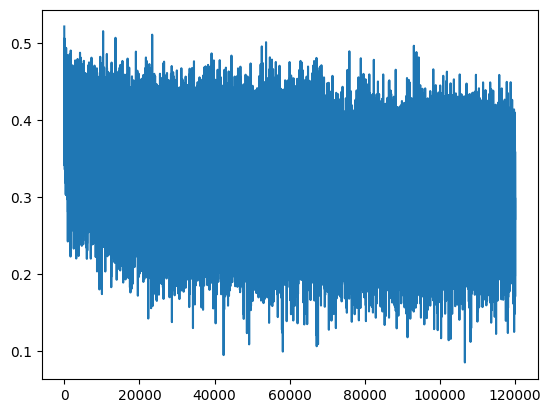

In [179]:
plt.plot(lossi)

In [180]:
# calibrate batch norm at the end of training
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure mean and std over entire training set
    bnmean = hpreact.mean(0, keepdims=True)
    bnstd = hpreact.std(0, keepdims=True)

In [181]:
@torch.no_grad() # this disables gradient tracking, makes evaluating faster, torch doesn't track computation graph
def split_loss(split):
    x,y = {'train': (Xtr, Ytr), 'dev': (Xdev, Ydev), 'test': (Xtest, Ytest)}[split]
    emb = C[x] # (N, block_size, n_emb)
    embcat = emb.view(-1, n_emb*block_size) # (N, block_size * n_emb)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('dev')

train 1.9870141744613647
dev 2.06160044670105


In [182]:
# sample from the model

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with '...'
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_emb)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

baxcharklissonavdusamithm.
blgav.
bonly.
bleia.
brysxmaddhixphrtsigshvequxgbasdel.
covandetsh.
benchisruemszydh.
bruxlhnesmodhica.
brexci.
riliana.
henddahish.
frtndastzo.
bzavi.
laysan.
gixmanelssnnyolshitor.
bdavam.
blavonnngalistachammraambry.
brexcluce.
fblncingsskgernlyjmekllytzo.
largannshap.


Initial loss: at initialization, we would expect all characters to have a roughly equal chance of being selected; the loss shoud therefore be around -log(1/27.0) or 3.29. If the loss is really high, the network's initialization is very confidently wrong in its predictions. To ensure the output probabilities are roughly uniform, we want the logits to all be similar in value and near 0. We can improve this by initializing bias vector to zeros and scaling down the weights that produce logits. 
* When training a neural network, we don't want a hockey stick loss plot, save that compute for actual gains at the right end of the plot. 

Saturated tanh: If activated layer has a high number of -1s and 1s, we have a highly active tanh unit that will effectively stop backprop through it. Chain rule, gradient is (1-t^2) * out.grad. If activations are mostly -1s and 1s, that implies that the pre-activated layer has a large spread. Aim to have pre-activated layer in active part of tanh, but not too small (else gradients will pass straight through), so that they are trained more.

Initialize weights by dividing by square root of fan_in to maintain variance of weights after going through activations. Check out Kaiming init torch documentation for specific values for different activations. A good number to scale all but final layer of weights is 5/3. The intuition behind this is non-linear layers like tanh are "squashing" functions that reduce the spread of your distribution, if you have enough layers, the std would theoretically converge to 0. To combat this, multiply by a scaling factor like 5/3 to combat this squashing of weights, 5/3 ensures std around 0.65 and saturation of highly active tanh units to 5%.

Batch normalization: goal is to have weights that have normal distribution (mean 0, std 1) at initialization. Normalize weights by batch by subtracting the mean of all examples and dividing by standard deviation. Allow neural network to learn how to orient these weights by scaling/shifting with gain (1s) and bias (0s). In practice, can batch normalize all linear/convolutional layers. 
    - Also, no point in having bias vector before computing activations because they get subtracted out when normalizing. 
    - Typically keep a smaller momentum for smaller batch sizes because mean and std will vary more, so don't want to emphasize any one batch if it is 'jittery.'
    
Make sure you aren't taking too big a step in the gradient direction, i.e. ensure gradient:data ratio is small.

General rule of thumb: want symmetry among parameters, should be normally distributed, parameters should update at similar rates. high saturation,  wide spread in std's or gradients can lead to issues for deep networks. 

In [112]:
# building out the lego blocks

class Linear: 
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.randn(fan_out) if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [160]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2)
C = torch.randn((vocab_size, n_emb), generator=g)

layers = [
    Linear(n_emb * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident (scale down layer that produces logits)
    layers[-1].gamma *= 0.1
    # all other layers: apply Kaining gain
    for l in layers[:-1]:
        if isinstance(l, Linear):
            l.weight *= 1.0

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(len(parameters))
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

25
47551


In [161]:
# Optimization
iters = 200001
batch_size = 32
lossi = []
ud = []

for i in range(iters):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors
    x = emb.view(-1, block_size*n_emb) # concatenate vectors 
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i % 10000 == 0: # print every 10000 steps
        print(f'{i:7d} / {iters-1:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break

      0 /  200000: 3.3184


layer 2 (      Tanh): mean -0.01, std 0.63, saturated: 2.72%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean -0.01, std 0.64, saturated: 2.72%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 2.06%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.97%


Text(0.5, 1.0, 'Activation distribution')

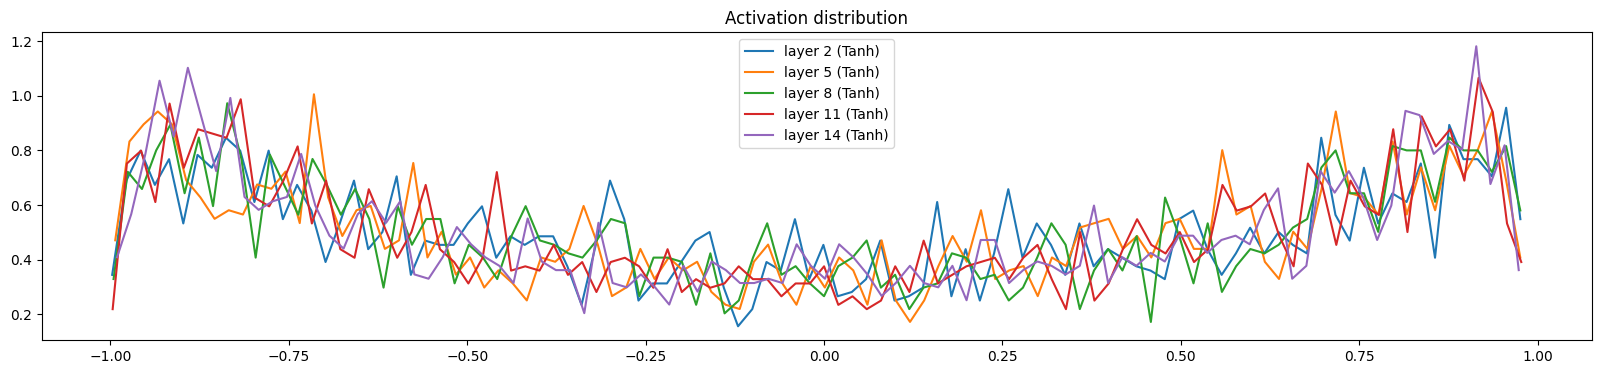

In [162]:
# visualize activations
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    
plt.legend(legends);
plt.title("Activation distribution")

layer 2 (      Tanh): mean -0.000000, std 2.617352e-03
layer 5 (      Tanh): mean -0.000000, std 2.320374e-03
layer 8 (      Tanh): mean -0.000000, std 2.226876e-03
layer 11 (      Tanh): mean +0.000000, std 2.132839e-03
layer 14 (      Tanh): mean +0.000000, std 2.053626e-03


Text(0.5, 1.0, 'gradients of tanh distribution')

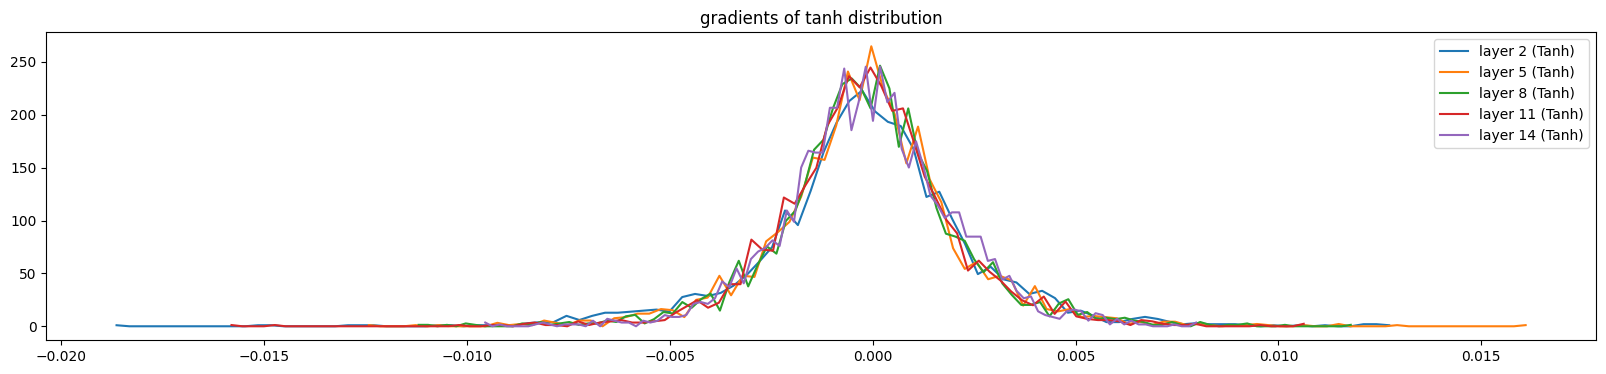

In [163]:
# visualize gradients
plt.figure(figsize=(20,4))
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
    
plt.legend(legends);
plt.title("gradients of tanh distribution")

weight   (27, 10) | mean -0.000000 | std 8.986116e-03 | grad:data ratio 9.623121e-03
weight  (30, 100) | mean +0.000095 | std 1.138373e-02 | grad:data ratio 6.154174e-02
weight (100, 100) | mean +0.000001 | std 8.018065e-03 | grad:data ratio 7.846160e-02
weight (100, 100) | mean -0.000164 | std 7.106627e-03 | grad:data ratio 7.051565e-02
weight (100, 100) | mean -0.000171 | std 6.736161e-03 | grad:data ratio 6.575578e-02
weight (100, 100) | mean -0.000079 | std 6.487774e-03 | grad:data ratio 6.356975e-02
weight  (100, 27) | mean -0.000002 | std 1.338220e-02 | grad:data ratio 1.258996e-01


Text(0.5, 1.0, 'gradients of weights distribution')

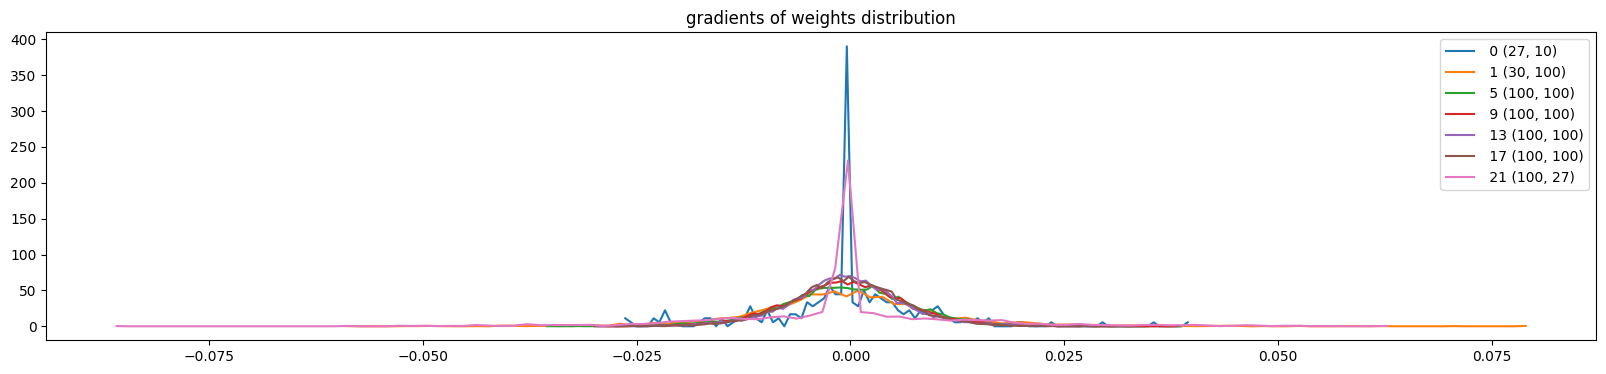

In [164]:
# visualize gradients
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # looking at weights, no biases or gammas/betas in BatchNorm
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f' {i} {tuple(p.shape)}')
    
plt.legend(legends);
plt.title("gradients of weights distribution")

Text(0.5, 1.0, 'size of update to data in log scale over time')

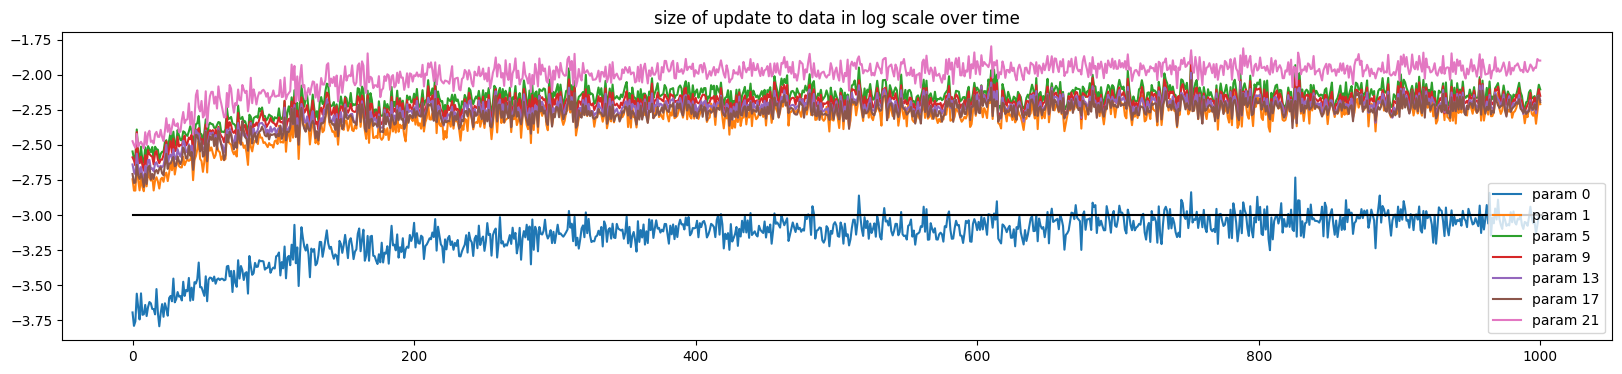

In [165]:
# update:data ratio over time
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2: # looking at weights, no biases or gammas/betas in BatchNorm
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends);
plt.title("size of update to data in log scale over time")